In [1]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt

In [2]:
import warnings

In [3]:
pd.set_option("display.max_columns",None)

In [4]:
#sklearn.set_config(transform_output="pandas")

In [5]:
warnings.filterwarnings("ignore")

In [6]:
path = "/Users/mukulagarwal/Desktop/Python_Code/flights_sagemaker_project/Data/train.csv"
train = pd.read_csv(path)

In [7]:
train = train.dropna()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          639 non-null    object 
 1   date_of_journey  639 non-null    object 
 2   source           639 non-null    object 
 3   destination      639 non-null    object 
 4   dep_time         639 non-null    object 
 5   arrival_time     639 non-null    object 
 6   duration         639 non-null    int64  
 7   total_stops      639 non-null    float64
 8   additional_info  639 non-null    object 
 9   price            639 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 54.9+ KB


In [9]:
X_train = train.drop(columns=['price'])
y_train = train['price']

## Airline

In [10]:
X_train['airline']

0            Jet Airways
1                 Indigo
2            Jet Airways
3      Multiple Carriers
4                 Indigo
             ...        
635            Air India
636            Air India
637          Jet Airways
638          Jet Airways
639          Jet Airways
Name: airline, Length: 639, dtype: object

In [11]:
train['airline'].value_counts()

airline
Jet Airways          236
Indigo               125
Air India             94
Multiple Carriers     73
Spicejet              55
Vistara               26
Goair                 16
Air Asia              14
Name: count, dtype: int64

In [12]:
from sklearn.impute import SimpleImputer
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import (
    OneHotEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [13]:
l1 = list(train['airline'].value_counts().index[:4])
t1 = train.copy()
t1.loc[[True if v not in l1 else False for v in train['airline'].values],'airline'] = 'other'

In [14]:
air_transformer = Pipeline(steps=[("imputer",SimpleImputer(strategy= 'most_frequent')),
                                  ("grouper",RareLabelEncoder(tol = 0.1,replace_with="other",n_categories=2)),
                                  ("ohe",OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

In [15]:
air_transformer.fit_transform(X_train.loc[:,['airline']])

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Date of journey

In [16]:
X_train['date_of_journey']

0      2019-12-03
1      2019-03-06
2      2019-09-05
3      2019-05-27
4      2019-03-18
          ...    
635    2019-06-06
636    2019-09-06
637    2019-06-24
638    2019-05-21
639    2019-05-21
Name: date_of_journey, Length: 639, dtype: object

In [17]:
from feature_engine.datetime import DatetimeFeatures
from sklearn.preprocessing import MinMaxScaler
features_to_extract = ['month','week','day_of_week','day_of_year']

daoj_transformer = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract = features_to_extract,yearfirst = True,format = "mixed")),
    ("scaler",MinMaxScaler())
])

daoj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

array([[1.        , 1.        , 0.16666667, 0.99109792],
       [0.18181818, 0.1875    , 0.33333333, 0.18397626],
       [0.72727273, 0.72916667, 0.5       , 0.72700297],
       ...,
       [0.45454545, 0.52083333, 0.        , 0.51038576],
       [0.36363636, 0.41666667, 0.16666667, 0.40949555],
       [0.36363636, 0.41666667, 0.16666667, 0.40949555]])

## Source and Destination

In [18]:
location_subset = X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Banglore,New Delhi
1,Mumbai,Hyderabad
2,Kolkata,Banglore
3,Delhi,Cochin
4,Chennai,Kolkata
...,...,...
635,Kolkata,Banglore
636,Delhi,Cochin
637,Delhi,Cochin
638,Delhi,Cochin


In [19]:
from feature_engine.encoding import MeanEncoder
from sklearn.preprocessing import PowerTransformer

location_pipe1 = Pipeline(steps = [
    ('grouper',RareLabelEncoder(tol = 0.1,replace_with='other',n_categories=2)),
    ('encoder',MeanEncoder()),
    ('symm_transf',PowerTransformer())
])

location_pipe1.fit_transform(location_subset,y_train)

array([[-0.75053872, -1.33161523],
       [-1.90096247, -1.33161523],
       [-0.25593887, -0.09107071],
       ...,
       [ 1.0482795 ,  1.0460648 ],
       [ 1.0482795 ,  1.0460648 ],
       [-0.25593887, -0.09107071]])

In [20]:
def is_north(X):
    columns = X.columns.to_list()
    return np.array(
                X.assign(**{ f"{col}_is_north" : X.loc[:,col].isin(['New Delhi','Kolkata','Delhi','Mumbai']).astype(int)  
                             for col in columns}
                         )
                .drop(columns=['source','destination'])
            )
is_north(location_subset)

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [21]:
from sklearn.preprocessing import FunctionTransformer
FunctionTransformer(is_north).fit_transform(location_subset)

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [22]:
from sklearn.pipeline import FeatureUnion
location_transformer = FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(is_north))
])

location_transformer.fit_transform(location_subset,y_train)

array([[-0.75053872, -1.33161523,  0.        ,  1.        ],
       [-1.90096247, -1.33161523,  1.        ,  0.        ],
       [-0.25593887, -0.09107071,  1.        ,  0.        ],
       ...,
       [ 1.0482795 ,  1.0460648 ,  1.        ,  0.        ],
       [ 1.0482795 ,  1.0460648 ,  1.        ,  0.        ],
       [-0.25593887, -0.09107071,  1.        ,  0.        ]])

## Dep_Time and Arrival_Time

In [23]:
time_subset = X_train[['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,08:55:00,21:20:00
1,01:40:00,03:10:00
2,20:00:00,04:40:00
3,11:30:00,19:15:00
4,07:55:00,10:15:00
...,...,...
635,08:20:00,21:50:00
636,09:45:00,23:00:00
637,02:15:00,04:25:00
638,13:00:00,04:25:00


In [24]:
time_pipe1 = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

array([[0.34782609, 1.        , 0.91304348, 0.36363636],
       [0.04347826, 0.72727273, 0.13043478, 0.18181818],
       [0.86956522, 0.        , 0.17391304, 0.72727273],
       ...,
       [0.08695652, 0.27272727, 0.17391304, 0.45454545],
       [0.56521739, 0.        , 0.17391304, 0.45454545],
       [0.86956522, 0.45454545, 0.39130435, 0.81818182]])

In [25]:
def part_of_day(X,morning=4,noon=12,evening = 16, night = 20):
    temp_x = X.assign(
        **{
            col : pd.to_datetime(X[col]).dt.hour
            for col in X.columns
        }
    )
    return temp_x.assign(
        **{
            f"{col}_part_of_day": np.select(
                [temp_x.loc[:,col].between(morning,noon,inclusive = 'left'),
                 temp_x.loc[:,col].between(noon,evening,inclusive = 'left'),
                 temp_x.loc[:,col].between(evening,night,inclusive = 'left')],
                ['morning','noon','evening'],
                default='night'
            )
            for col in temp_x.columns
        }
    ).drop(columns = ['dep_time','arrival_time'])

In [26]:
from feature_engine.encoding import CountFrequencyEncoder
time_pipe2 = Pipeline(steps=[
    ('part_of_day',FunctionTransformer(part_of_day)),
    ('count_encoder',CountFrequencyEncoder()),
    ('scale',MinMaxScaler())
])

In [27]:
time_transformer = FeatureUnion(
    transformer_list=[
        ('part1',time_pipe1),
        ('part2',time_pipe2)
    ]
)

time_transformer.fit_transform(time_subset)

array([[0.34782609, 1.        , 0.91304348, 0.36363636, 1.        ,
        1.        ],
       [0.04347826, 0.72727273, 0.13043478, 0.18181818, 0.08571429,
        1.        ],
       [0.86956522, 0.        , 0.17391304, 0.72727273, 0.08571429,
        0.95698925],
       ...,
       [0.08695652, 0.27272727, 0.17391304, 0.45454545, 0.08571429,
        0.95698925],
       [0.56521739, 0.        , 0.17391304, 0.45454545, 0.        ,
        0.95698925],
       [0.86956522, 0.45454545, 0.39130435, 0.81818182, 0.08571429,
        0.95698925]])

In [28]:
X_train[['duration']].quantile([0.25,0.5,0.75]).values

array([[170. ],
       [480. ],
       [902.5]])

## Duration

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
    
    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()
        reference_values = X[self.variables].quantile(self.percentiles).values
        self.reference_values_ = {self.variables[i] : reference_values[:,i].reshape(-1,1) for i in range(len(self.variables))}
        return self
    
    def transform(self,X):
        objects = []
        for col in self.variables:           
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns)
            objects.append(obj)      
        return pd.concat(objects,axis=1)  

In [30]:
def duration_cat(X,short=180,medium=400):
    return(
        X.assign(
            duration_cat = np.select([X['duration'].lt(short),
                                      X['duration'].between(short,medium,inclusive = 'left')],
                                     ['short','medium'],
                                     default='long')
        )
        .drop(columns = ['duration'])
    )
duration_cat(X_train[['duration']])    

,duration_cat
0,long
1,short
2,long
3,long
4,short
...,...
635,long
636,long
637,long
638,long


In [31]:
def is_over(X,value = 1000):
    return (
        X.assign(
            duration_is_over = lambda df_ : df_['duration'].ge(1000).astype(int)
        )
        .drop(columns = 'duration')
    )
    
is_over(X_train[['duration']])

,duration_is_over
0,0
1,0
2,0
3,0
4,0
...,...
635,0
636,0
637,1
638,0


In [32]:
RBFPercentileSimilarity(['duration']).fit_transform(X_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.000000e+00,0.000000e+00
1,1.125982e-278,0.000000e+00,0.000000e+00
2,0.000000e+00,3.257489e-70,0.000000e+00
3,0.000000e+00,1.691898e-10,0.000000e+00
4,8.194013e-40,0.000000e+00,0.000000e+00
...,...,...,...
634,0.000000e+00,0.000000e+00,0.000000e+00
635,0.000000e+00,0.000000e+00,0.000000e+00
636,0.000000e+00,0.000000e+00,0.000000e+00
637,0.000000e+00,0.000000e+00,1.032385e-22


In [33]:
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
duration_pipe1 = Pipeline(steps=[
	#("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_cat)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	#("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median"))
	#("union", duration_union)
])

#duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

In [34]:
X_train['total_stops'].astype(int) == 0

0      False
1       True
2      False
3      False
4       True
       ...  
635    False
636    False
637    False
638    False
639    False
Name: total_stops, Length: 639, dtype: bool

In [35]:
def is_more_than_one(X):
    return(
        X.assign(
            is_direct_flight = lambda df_: (df_['total_stops'].astype(int) == 0).astype(int)   
        )
    )
is_more_than_one(X_train)

total_stops_transformer = Pipeline(steps=[
    ('is_direct',FunctionTransformer(is_more_than_one))
])
total_stops_transformer.fit_transform(X_train[['total_stops']])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,1.0,0
4,0.0,1
...,...,...
635,2.0,0
636,1.0,0
637,1.0,0
638,1.0,0


In [36]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [37]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [38]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [39]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

#info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

In [40]:
def convert_to_numpy(X):
    return X

## Column Transformer

In [41]:
column_transformer = ColumnTransformer(transformers=[
    ('air',air_transformer,["airline"]),
    ('doj_column',daoj_transformer,["date_of_journey"]),
    ('location',location_pipe1,["source","destination"]),
    ('time',time_pipe1,["dep_time","arrival_time"]),
    ('dur',duration_transformer,["duration"]),
    #('stops',total_stops_transformer,["total_stops"]),
    ("info", info_pipe1, ["additional_info"])
],remainder='passthrough')

In [42]:
val_data = pd.read_csv("/Users/mukulagarwal/Desktop/Python_Code/flights_sagemaker_project/Data/val.csv")
val_data = column_transformer.fit_transform(val_data.drop(columns='price'),val_data['price'])

In [43]:
val_data

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

### Model Training 

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor)
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    'lr' : LinearRegression(),
    'gb' : GradientBoostingRegressor(),
    'rf' : RandomForestRegressor(),
    'cat' : CatBoostRegressor(verbose=False),
    'ada' : AdaBoostRegressor(),
    'hist' : HistGradientBoostingRegressor()
}

metric_dict = {}

for estimator in models:
     model_pipeline = Pipeline(steps=[
         ('transform',column_transformer),
         ('reg',models[estimator])
     ])
     
     val_scores = cross_val_score(model_pipeline,X_train,y_train,cv=5,scoring = 'r2')
     val_score = np.mean(val_scores)
     metric_dict[models[estimator].__class__.__name__]=val_score
     print(models[estimator].__class__.__name__,"-",{val_score})     

LinearRegression - {0.6315910289903467}
GradientBoostingRegressor - {0.7598152675402464}
RandomForestRegressor - {0.7445624139093087}
CatBoostRegressor - {0.7649538523453895}
AdaBoostRegressor - {0.5522276770741232}
HistGradientBoostingRegressor - {0.7335926416256461}


In [45]:
best_model = pd.DataFrame(data = metric_dict.items(),columns=['model','r2_score']).sort_values(by='r2_score',ascending=False).reset_index().loc[0,'model']
metric_dict[best_model]

0.7649538523453895

In [46]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [47]:
from sklearn.model_selection import learning_curve
def plot_learning_curves(name, algorithm, figsize=(12, 4),X = X_train,y = y_train):
	model = Pipeline(steps=[
		("pre", column_transformer),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X,
		y=y,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)
 
	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
	ax.legend(loc="lower right")
	ax.grid()
	plt.show()

/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each eleme

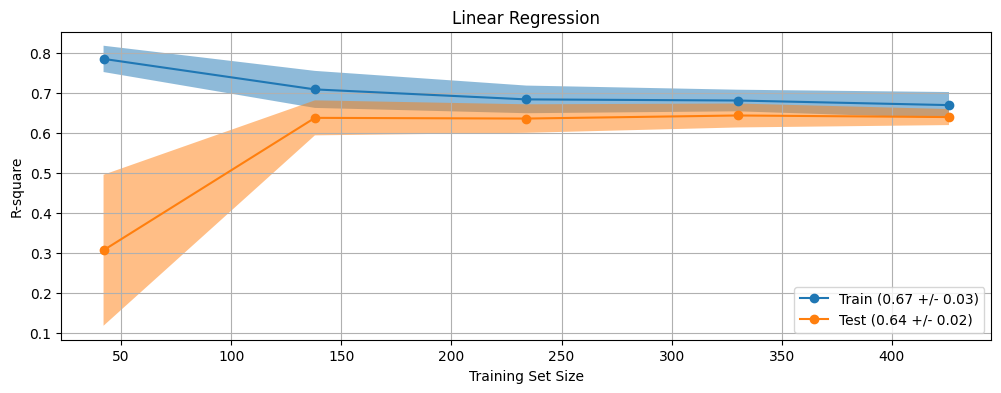

/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each eleme

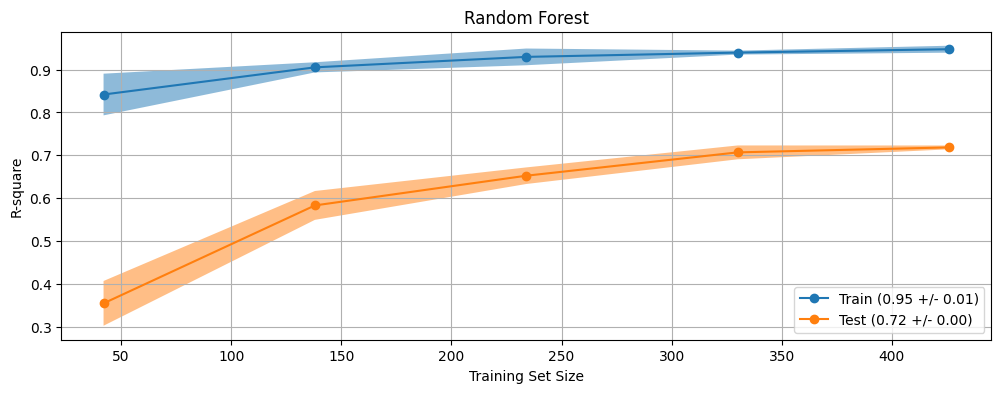

/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each eleme

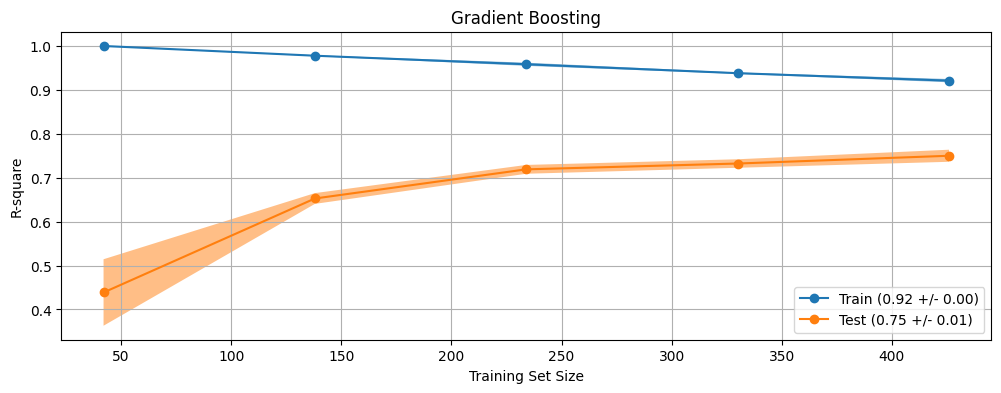

In [48]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
    'Gradient Boosting' : GradientBoostingRegressor()
}
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

In [49]:
model_pipeline = Pipeline(steps=[
         ('transform',column_transformer),
         ('reg',GradientBoostingRegressor())
     ])

In [50]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('transform',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('air',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('grouper',
                                                     RareLabelEncoder(n_categories=2,
                                                                      replace_with='other',
                                                                      tol=0.1)),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['airline']),
                                   ('doj_column',
                                    Pipelin

### Model Hyperparameter Tuning

In [51]:
import optuna
from functools import partial
def objective_func(trial,model,X_train,y_train):
    reg__subsample = trial.suggest_float('reg__subsample',0,1)
    reg__min_samples_split = trial.suggest_float('reg__min_samples_split',0,1)
    reg__max_depth = trial.suggest_int('reg__max_depth',1,10,step=1)
    reg__n_estimators = trial.suggest_int('reg__n_estimators',100,1200,step = 100)
    reg__criterion = trial.suggest_categorical('reg__criterion',['friedman_mse', 'squared_error'])
    
    model = model.set_params(reg__subsample = reg__subsample,
                  reg__min_samples_split = reg__min_samples_split,
                  reg__max_depth = reg__max_depth,
                  reg__n_estimators = reg__n_estimators,
                  reg__criterion = reg__criterion)
    
    return cross_val_score(model,
                           X_train,
                           y_train,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1).mean()
    
optimization_func = partial(objective_func,
                            model = model_pipeline,
                            X_train = X_train,
                            y_train = y_train) 


In [52]:
study = optuna.create_study(direction='maximize')
study.optimize(optimization_func, n_trials=100)

[I 2024-10-02 12:58:51,431] A new study created in memory with name: no-name-dd3aef8d-3743-4a3b-a260-fc525ec0869d
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/python3.12/site-packages/feature_engine/datetime/datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/opt/miniconda3/lib/py

In [53]:
study.best_params

{'reg__subsample': 0.9260566371185797,
 'reg__min_samples_split': 0.16099433876704308,
 'reg__max_depth': 3,
 'reg__n_estimators': 300,
 'reg__criterion': 'friedman_mse'}

In [54]:
study.best_value

0.7764287225201729

In [55]:
study.best_trial

FrozenTrial(number=91, state=1, values=[0.7764287225201729], datetime_start=datetime.datetime(2024, 10, 2, 12, 59, 23, 253044), datetime_complete=datetime.datetime(2024, 10, 2, 12, 59, 23, 574227), params={'reg__subsample': 0.9260566371185797, 'reg__min_samples_split': 0.16099433876704308, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__criterion': 'friedman_mse'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reg__subsample': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg__min_samples_split': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg__max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'reg__n_estimators': IntDistribution(high=1200, log=False, low=100, step=100), 'reg__criterion': CategoricalDistribution(choices=('friedman_mse', 'squared_error'))}, trial_id=91, value=None)

In [56]:
study.best_trials

[FrozenTrial(number=91, state=1, values=[0.7764287225201729], datetime_start=datetime.datetime(2024, 10, 2, 12, 59, 23, 253044), datetime_complete=datetime.datetime(2024, 10, 2, 12, 59, 23, 574227), params={'reg__subsample': 0.9260566371185797, 'reg__min_samples_split': 0.16099433876704308, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__criterion': 'friedman_mse'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'reg__subsample': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg__min_samples_split': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg__max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'reg__n_estimators': IntDistribution(high=1200, log=False, low=100, step=100), 'reg__criterion': CategoricalDistribution(choices=('friedman_mse', 'squared_error'))}, trial_id=91, value=None)]

### Save Model

In [57]:
import dill
preprocessor_pipeline = Pipeline(steps=[
         ('preprocessor',column_transformer)
     ])
path_preprocessor = '/Users/mukulagarwal/Desktop/Python_Code/flights_sagemaker_project/preprocessor.pkl'

model_pipeline = Pipeline(steps=[
         ('reg',GradientBoostingRegressor())
     ])

path_model = '/Users/mukulagarwal/Desktop/Python_Code/flights_sagemaker_project/model.pkl'

X_train_transform = preprocessor_pipeline.fit_transform(X_train,y_train)
with open(path_preprocessor, 'wb') as file:
    dill.dump(preprocessor_pipeline, file)

model = model_pipeline.set_params(**study.best_params)
model_pipeline.fit(X_train_transform,y_train)

with open(path_model, 'wb') as file:
    dill.dump(model_pipeline, file)

### Load_Model

In [58]:
from sklearn.metrics import mean_squared_error,r2_score
test_data = pd.read_csv("/Users/mukulagarwal/Desktop/Python_Code/flights_sagemaker_project/Data/test.csv")
with open(path_preprocessor, 'rb') as file:
    preprocessor = dill.load(file)
test_X = preprocessor.transform(test_data.drop(columns='price'))

with open(path_model, 'rb') as file:
    model = dill.load(file)
r2_score(test_data['price'],model.predict(test_X))

0.7953435074591194

### Get Pipeline Params

In [59]:
list(model.get_params().keys())

['memory',
 'steps',
 'verbose',
 'reg',
 'reg__alpha',
 'reg__ccp_alpha',
 'reg__criterion',
 'reg__init',
 'reg__learning_rate',
 'reg__loss',
 'reg__max_depth',
 'reg__max_features',
 'reg__max_leaf_nodes',
 'reg__min_impurity_decrease',
 'reg__min_samples_leaf',
 'reg__min_samples_split',
 'reg__min_weight_fraction_leaf',
 'reg__n_estimators',
 'reg__n_iter_no_change',
 'reg__random_state',
 'reg__subsample',
 'reg__tol',
 'reg__validation_fraction',
 'reg__verbose',
 'reg__warm_start']

### Ignore this piece (Practice/Experiments)

In [60]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    
    'reg__n_estimators': [n for n in range(50, 201, 8)],
    'reg__criterion': ['poisson', 'friedman_mse', 'squared_error', 'absolute_error'],
    'reg__max_depth': [3, 4, 5, 6, 7, 8],
    'reg__max_features': ['auto', 'log2']    
}

rnfcgs = RandomizedSearchCV(estimator=model_pipeline, 
                            param_distributions=params, 
                            n_iter=100, 
                            cv=5, 
                            random_state=42)

rnfcgs.fit(X_train, y_train)

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of GradientBoostingRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of GradientBoostingRegressor must be a str among {'squared_error', 'friedman_mse'}. Got 'absolute_error' instead.

--------------------------------------------------------------------------------
130 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 659, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Jet Airways'

--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of GradientBoostingRegressor must be a str among {'squared_error', 'friedman_mse'}. Got 'poisson' instead.


In [ ]:
rnfcgs.best_params_

In [ ]:
rnfcgs.best_score_

In [565]:
class transformer_name(BaseEstimator,TransformerMixin):
    def __init__(self,threshold,column_name):
        self.threshold = threshold
        self.column_name = column_name
        
    def fit(self,X):
        pass
    
    def transform(self,X):
        return pd.DataFrame(data = X.loc[:,self.column_name].ge(self.threshold).astype(int).values,
                            columns=['duration_'])

In [ ]:
X_train.loc[:,'duration'].ge(1000).astype(int)

In [567]:
a = transformer_name(1000,'duration')

In [ ]:
a.transform(X_train)

In [570]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
classifer = RandomForestClassifier()
param_grid = {
    "n_estimators" : [100,200,300,400],
    "max_depth" : [1,3,5,7],
    "criterion" : ['gini','entropy']
}

model = GridSearchCV(
    estimator = classifer,
    param_grid = param_grid,
    scoring = "accuracy",
    verbose = 10,
    cv = 5
)

In [571]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
pca = decomposition.PCA()
rf = RandomForestClassifier()

classifier = Pipeline(steps=[
    ('scaling' , scl),
    ('pca',pca),
    ('rf',rf)
])

param_grid = {
    "pca__n_components" : [1,4,6,7,8,9],
    "rf__n_estimators" : [100,200,300,400],
    "rf__max_depth" : [1,3,5,7],
    "rf__criterion" : ['gini','entropy']
}

model = GridSearchCV(
    estimator = classifer,
    param_grid = param_grid,
    scoring = "accuracy",
    verbose = 10,
    cv = 5
)